In [31]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

In [32]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [33]:
IT_finance = pd.read_excel('./data/dongboo/IT_TOTAL_재무사항.xlsx')
IT_nonfinance = pd.read_excel('./data/dongboo/비재무/IT_비재무_TOTAL_최종.xlsx')

IT_validation_finance = pd.read_excel('./data/dongboo/IT_validation_재무사항.xlsx')
IT_validation_nonfinance = pd.read_excel('./data/dongboo/비재무validation/validation_비재무_it_total_최종.xlsx')

In [34]:
# krx에서 가져온 자료
IT_stock = pd.read_excel('./data/dongboo/IT_주가_total_krx.xlsx')

IT_validation_stock = pd.read_excel('./data/dongboo/IT_validation_주가.xls')

# IT_stock = pd.read_excel('./data/dongboo/IT_TOTAL_주가.xlsx')
# Medicine_stock = pd.read_excel('./data/dongboo/제약_TOTAL_주가.xlsx')

In [35]:
IT_info = pd.merge(IT_finance,IT_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])
IT_val_info = pd.merge(IT_validation_finance,IT_validation_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [36]:
IT = pd.merge(IT_info, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])
IT_val = pd.merge(IT_val_info,IT_validation_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])

In [37]:
IT_fi = pd.merge(IT_finance, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])
IT_no_fi = pd.merge(IT_nonfinance, IT_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])

In [38]:
lg = IT[IT['회사명'] == 'LG이노텍(주)']
sdi = IT[IT['회사명'] == '삼성SDI(주)']
ssem = IT[IT['회사명'] == '삼성전기(주)']
hynix = IT[IT['회사명'] == '에스케이하이닉스(주)']

# ------------- validation ------------------

samsungelectric = IT_val[IT_val['회사명'] == '삼성전자(주)']
lgelectric = IT_val[IT_val['회사명'] == '엘지전자(주)']
sds = IT_val[IT_val['회사명'] == '삼성에스디에스(주)']
lgdisplay = IT_val[IT_val['회사명'] == '엘지디스플레이(주)']

In [39]:
lg_f = IT_fi[IT_fi['회사명'] == 'LG이노텍(주)']
sdi_f = IT_fi[IT_fi['회사명'] == '삼성SDI(주)']
ssem_f = IT_fi[IT_fi['회사명'] == '삼성전기(주)']
hynix_f = IT_fi[IT_fi['회사명'] == '에스케이하이닉스(주)']


In [40]:
lg_nf = IT_no_fi[IT_no_fi['회사명'] == 'LG이노텍(주)']
sdi_nf = IT_no_fi[IT_no_fi['회사명'] == '삼성SDI(주)']
ssem_nf = IT_no_fi[IT_no_fi['회사명'] == '삼성전기(주)']
hynix_nf = IT_no_fi[IT_no_fi['회사명'] == '에스케이하이닉스(주)']

In [41]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [42]:
classify(lg)
classify(sdi)
classify(ssem)
classify(hynix)

classify(lg_f)
classify(sdi_f)
classify(ssem_f)
classify(hynix_f)

classify(lg_nf)
classify(sdi_nf)
classify(ssem_nf)
classify(hynix_nf)

# ------------- validation ------------------

classify(samsungelectric)
classify(lgelectric)
classify(sds)
classify(lgdisplay)

KeyboardInterrupt: 

In [ ]:
lg = lg.iloc[:-1,:]
sdi = sdi.iloc[:-1,:]
ssem = ssem.iloc[:-1,:]
hynix = hynix.iloc[:-1,:]

lg_f = lg_f.iloc[:-1,:]
sdi_f = sdi_f.iloc[:-1,:]
ssem_f = ssem_f.iloc[:-1,:]
hynix_f = hynix_f.iloc[:-1,:]

lg_nf = lg_nf.iloc[:-1,:]
sdi_nf = sdi_nf.iloc[:-1,:]
ssem_nf = ssem_nf.iloc[:-1,:]
hynix_nf = hynix_nf.iloc[:-1,:]

# ------------- validation ------------------

samsungelectric = samsungelectric.iloc[:-1,:]
lgelectric = lgelectric.iloc[:-1,:]
sds = sds.iloc[:-1,:]
lgdisplay = lgdisplay.iloc[:-1,:]

In [ ]:
lg_f_corr = lg_f.corr(method = 'pearson')
df_lg_f = pd.DataFrame(lg_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg_f.columns = ['지표','3개월후종가']

sdi_f_corr = sdi_f.corr(method = 'pearson')
df_sdi_f = pd.DataFrame(sdi_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi_f.columns = ['지표','3개월후종가']

ssem_f_corr = ssem_f.corr(method = 'pearson')
df_ssem_f = pd.DataFrame(ssem_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem_f.columns = ['지표','3개월후종가']

hynix_f_corr = hynix_f.corr(method = 'pearson')
df_hynix_f = pd.DataFrame(hynix_f_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix_f.columns = ['지표','3개월후종가']

In [ ]:
lg_nf_corr = lg_nf.corr(method = 'pearson')
df_lg_nf = pd.DataFrame(lg_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg_nf.columns = ['지표','3개월후종가']

sdi_nf_corr = sdi_nf.corr(method = 'pearson')
df_sdi_nf = pd.DataFrame(sdi_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi_nf.columns = ['지표','3개월후종가']

ssem_nf_corr = ssem_nf.corr(method = 'pearson')
df_ssem_nf = pd.DataFrame(ssem_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem_nf.columns = ['지표','3개월후종가']

hynix_nf_corr = hynix_nf.corr(method = 'pearson')
df_hynix_nf = pd.DataFrame(hynix_nf_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix_nf.columns = ['지표','3개월후종가']

In [ ]:
list_corr = []
order = 30 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg_f.index[:order])):
    list_corr.append(df_lg_f.index[:order][i])
    list_corr.append(df_sdi_f.index[:order][i])
    list_corr.append(df_ssem_f.index[:order][i])
    list_corr.append(df_hynix_f.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

var = []

for i in range(len(variable)):
    var.append(df_lg_f[df_lg_f.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]

corr = corr[corr['var'] != '3개월후종가'].reset_index(drop = True)
corr = corr[corr['var'] != '수익률상승하락'].reset_index(drop = True)
corr = corr[corr['var'] != '분기수익률'].reset_index(drop = True)
corr

In [ ]:
list_corr_nf = []
order = 15 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg_nf.index[:order])):
    list_corr_nf.append(df_lg_nf.index[:order][i])
    list_corr_nf.append(df_sdi_nf.index[:order][i])
    list_corr_nf.append(df_ssem_nf.index[:order][i])
    list_corr_nf.append(df_hynix_nf.index[:order][i])

variable_nf = pd.Series(list_corr_nf).value_counts()
variable_nf = pd.DataFrame(variable_nf).reset_index()
variable_nf.columns = ['var_index', 'number']

var_nf = []


for i in range(len(variable_nf)):
    var_nf.append(df_lg_nf[df_lg_nf.index == variable_nf['var_index'][i]]['지표'].values[0])
var_nf = pd.DataFrame(var_nf)
var_nf.columns = ['var']

corr_nf = pd.concat([variable_nf,var_nf], axis = 1)
corr_nf = corr_nf[['var_index','var','number']]

corr_nf = corr_nf[corr_nf['var'] != '3개월후종가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '수익률상승하락'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '분기수익률'].reset_index(drop = True)


corr_nf = corr_nf[corr_nf['var'] != '거래대금'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '종가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '최저가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '최고가'].reset_index(drop = True)
corr_nf = corr_nf[corr_nf['var'] != '거래량'].reset_index(drop = True)
corr_nf

In [ ]:
corr = pd.concat([corr[:10],corr_nf[:10]],axis = 0).reset_index(drop = True)

In [ ]:
deep_lg = lg[corr['var'][:20]]
deep_sdi = sdi[corr['var'][:20]]
deep_ssem = ssem[corr['var'][:20]]
deep_hynix = hynix[corr['var'][:20]]

deep_lg['수익률상승하락'] = lg['수익률상승하락']
deep_sdi['수익률상승하락'] = sdi['수익률상승하락']
deep_ssem['수익률상승하락'] = ssem['수익률상승하락']
deep_hynix['수익률상승하락'] = hynix['수익률상승하락']

deep_lg = deep_lg.dropna(axis = 0)
deep_ssem = deep_ssem.dropna(axis = 0)
deep_sdi = deep_sdi.dropna(axis = 0)
deep_hynix = deep_hynix.dropna(axis = 0)
# ------------ validation --------------

deep_samsungelectric = samsungelectric[corr['var'][0:20]]
deep_lgelectric = lgelectric[corr['var'][0:20]]
deep_sds = sds[corr['var'][0:20]]
deep_lgdisplay = lgdisplay[corr['var'][0:20]]

deep_samsungelectric['수익률상승하락'] = samsungelectric['수익률상승하락']
deep_lgelectric['수익률상승하락'] = lgelectric['수익률상승하락']
deep_sds['수익률상승하락'] = sds['수익률상승하락']
deep_lgdisplay['수익률상승하락'] = lgdisplay['수익률상승하락']

deep_samsungelectric = deep_samsungelectric.dropna(axis = 0)
deep_lgelectric = deep_lgelectric.dropna(axis = 0)
deep_sds = deep_sds.dropna(axis = 0)
deep_lgdisplay = deep_lgdisplay.dropna(axis = 0)

In [ ]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_lg = StandardScaler()
scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))

scaler_sdi = StandardScaler()
scale_sdi = pd.DataFrame(scaler_sdi.fit_transform(deep_sdi.iloc[:,:-1]))

scaler_ssem = StandardScaler()
scale_ssem = pd.DataFrame(scaler_ssem.fit_transform(deep_ssem.iloc[:,:-1]))

scaler_hynix = StandardScaler()
scale_hynix = pd.DataFrame(scaler_hynix.fit_transform(deep_hynix.iloc[:,:-1]))

# ------------ validation --------------

scaler_samsungelectric = StandardScaler()
scale_samsungelectric = pd.DataFrame(scaler_lg.fit_transform(deep_samsungelectric.iloc[:,:-1]))

scaler_lgelectric = StandardScaler()
scale_lgelectric = pd.DataFrame(scaler_sdi.fit_transform(deep_lgelectric.iloc[:,:-1]))

scaler_sds = StandardScaler()
scale_sds = pd.DataFrame(scaler_ssem.fit_transform(deep_sds.iloc[:,:-1]))

scaler_lgdisplay = StandardScaler()
scale_lgdisplay = pd.DataFrame(scaler_hynix.fit_transform(deep_lgdisplay.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [ ]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

# ------------ validation --------------

# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT_validation = pd.concat([deep_samsungelectric,deep_lgelectric,deep_sds,deep_lgdisplay], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT_validation = pd.concat([scale_samsungelectric,scale_lgelectric,scale_sds,scale_lgdisplay], ignore_index=True)

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib import font_manager, rc
# import seaborn as sns
# import matplotlib
# font_location = "c:/Windows/fonts/malgun.ttf"
# font_name = font_manager.FontProperties(fname=font_location).get_name()
# matplotlib.rc('font', family=font_name)

In [ ]:
# plt.figure(figsize=(20,50))

# sns.heatmap(data = scale_IT.corr(), annot = True)
# # plt.savefig('tmp.png')

# 샤비어함수 및 히든레이어 5개

# 및 Validation

In [ ]:
def xavier_init(n_inputs, n_outputs, uniform=True):
    if uniform:
        # 6 was used in the paper.
        init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limints as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

In [ ]:
# 히든레이어 1개 짜리!!!!

# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()

deep_IT = pd.concat([deep_hynix,deep_ssem,deep_sdi,deep_lg], ignore_index=True)
scale_IT = pd.concat([scale_hynix,scale_ssem,scale_sdi,scale_lg], ignore_index=True)

x_data = scale_IT
y_data = deep_IT.iloc[:,[-1]]


graph_cost = []
graph_acc = []

# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.001


X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 1], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([1]))

hypothesis = tf.sigmoid(tf.matmul(X, W1) + b1)


# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [ ]:
# # 히든레이어 5개 짜리!!!

# # Review : Learning rate and Evaluation
# import tensorflow as tf
# import random
# import matplotlib.pyplot as plt

# tf.set_random_seed(777)  # reproducibility
# tf.reset_default_graph()


# x_data = scale_IT
# y_data = deep_IT.iloc[:,[-1]]


# # parameters
# placeholder_num = len(x_data.columns)
# learning_rate = 0.0001




# X = tf.placeholder(tf.float32, [None, placeholder_num])
# Y = tf.placeholder(tf.float32, [None, 1])
# keep_prob = tf.placeholder(tf.float32)


# W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
# b1 = tf.Variable(tf.random_normal([32]))
# L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
# L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


# W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
# b2 = tf.Variable(tf.random_normal([64]))
# L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
# L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

# W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
# b3 = tf.Variable(tf.random_normal([64]))
# L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
# L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


# W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
# b4 = tf.Variable(tf.random_normal([32]))
# L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
# L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


# W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
# b5 = tf.Variable(tf.random_normal([1]))
# L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# # hypothesis = tf.matmul(L4, W5) + b5

# # define cost/loss & optimizer

# # Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
# hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# # cost/loss function
# cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
#                        tf.log(1 - hypothesis))

# train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# # train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# # Accuracy computation
# # True if hypothesis>0.5 else False
# predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
# accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

# <span style="color:red"> 가치주로 validation

In [47]:
# Launch graph

# validation_number = 3


#순서를 바꿔서 입력하자!



x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    
    for step in tqdm_notebook(range(100001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data_train, Y: y_data_train, keep_prob: 1.0})       
        if step % 200 == 0 or step < 10 :
            h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data_test, Y: y_data_test, keep_prob: 1.0})
            graph_cost.append(cost_val)
            graph_acc.append(a)
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

#     for step in tqdm_notebook(range(9001)):
#         cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 1.0})       
#         if step % 200 == 0 or step < 10 :
#             h, c, a = sess.run([hypothesis, predicted, accuracy],
#                        feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})
#             graph_cost.append(cost_val)
#             graph_acc.append(a)
#             print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

    # Accuracy report
#     h, c, a = sess.run([hypothesis, predicted, accuracy],
#                        feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 1.0336869955062866 	 Acc : 51.99999809265137
Step : 1 	 Cost : 1.0332937240600586 	 Acc : 51.99999809265137
Step : 2 	 Cost : 1.0329009294509888 	 Acc : 51.99999809265137
Step : 3 	 Cost : 1.0325087308883667 	 Acc : 51.99999809265137
Step : 4 	 Cost : 1.0321167707443237 	 Acc : 51.99999809265137
Step : 5 	 Cost : 1.031725525856018 	 Acc : 51.99999809265137
Step : 6 	 Cost : 1.0313342809677124 	 Acc : 51.99999809265137
Step : 7 	 Cost : 1.0309439897537231 	 Acc : 51.99999809265137
Step : 8 	 Cost : 1.0305540561676025 	 Acc : 51.99999809265137
Step : 9 	 Cost : 1.030164361000061 	 Acc : 51.99999809265137
Step : 200 	 Cost : 0.9639841914176941 	 Acc : 51.99999809265137
Step : 400 	 Cost : 0.9108708500862122 	 Acc : 60.00000238418579
Step : 600 	 Cost : 0.8710517287254333 	 Acc : 60.00000238418579
Step : 800 	 Cost : 0.8406764268875122 	 Acc : 60.00000238418579
Step : 1000 	 Cost : 0.8165317177772522 	 Acc : 56.00000023841858
Step : 1200 	 Cost : 0.7964419722557068 	 Acc 

Step : 22800 	 Cost : 0.5730970501899719 	 Acc : 63.999998569488525
Step : 23000 	 Cost : 0.5728350877761841 	 Acc : 63.999998569488525
Step : 23200 	 Cost : 0.5725756287574768 	 Acc : 63.999998569488525
Step : 23400 	 Cost : 0.5723185539245605 	 Acc : 63.999998569488525
Step : 23600 	 Cost : 0.5720638632774353 	 Acc : 63.999998569488525
Step : 23800 	 Cost : 0.5718114972114563 	 Acc : 63.999998569488525
Step : 24000 	 Cost : 0.5715614557266235 	 Acc : 63.999998569488525
Step : 24200 	 Cost : 0.571313738822937 	 Acc : 63.999998569488525
Step : 24400 	 Cost : 0.5710681676864624 	 Acc : 63.999998569488525
Step : 24600 	 Cost : 0.5708246827125549 	 Acc : 63.999998569488525
Step : 24800 	 Cost : 0.5705835223197937 	 Acc : 63.999998569488525
Step : 25000 	 Cost : 0.5703444480895996 	 Acc : 63.999998569488525
Step : 25200 	 Cost : 0.5701074600219727 	 Acc : 63.999998569488525
Step : 25400 	 Cost : 0.5698724985122681 	 Acc : 63.999998569488525
Step : 25600 	 Cost : 0.5696395039558411 	 Acc : 

Step : 46800 	 Cost : 0.55220627784729 	 Acc : 63.999998569488525
Step : 47000 	 Cost : 0.5520870685577393 	 Acc : 63.999998569488525
Step : 47200 	 Cost : 0.5519687533378601 	 Acc : 63.999998569488525
Step : 47400 	 Cost : 0.5518511533737183 	 Acc : 63.999998569488525
Step : 47600 	 Cost : 0.5517339110374451 	 Acc : 63.999998569488525
Step : 47800 	 Cost : 0.5516170263290405 	 Acc : 63.999998569488525
Step : 48000 	 Cost : 0.5515010952949524 	 Acc : 63.999998569488525
Step : 48200 	 Cost : 0.5513857007026672 	 Acc : 63.999998569488525
Step : 48400 	 Cost : 0.5512706637382507 	 Acc : 63.999998569488525
Step : 48600 	 Cost : 0.5511563420295715 	 Acc : 63.999998569488525
Step : 48800 	 Cost : 0.5510425567626953 	 Acc : 63.999998569488525
Step : 49000 	 Cost : 0.5509293079376221 	 Acc : 63.999998569488525
Step : 49200 	 Cost : 0.550816535949707 	 Acc : 63.999998569488525
Step : 49400 	 Cost : 0.550704300403595 	 Acc : 63.999998569488525
Step : 49600 	 Cost : 0.5505926609039307 	 Acc : 63.

Step : 70800 	 Cost : 0.541161298751831 	 Acc : 63.999998569488525
Step : 71000 	 Cost : 0.5410904288291931 	 Acc : 63.999998569488525
Step : 71200 	 Cost : 0.5410197973251343 	 Acc : 63.999998569488525
Step : 71400 	 Cost : 0.5409494042396545 	 Acc : 63.999998569488525
Step : 71600 	 Cost : 0.5408792495727539 	 Acc : 63.999998569488525
Step : 71800 	 Cost : 0.540809690952301 	 Acc : 63.999998569488525
Step : 72000 	 Cost : 0.5407402515411377 	 Acc : 63.999998569488525
Step : 72200 	 Cost : 0.540671169757843 	 Acc : 63.999998569488525
Step : 72400 	 Cost : 0.5406022667884827 	 Acc : 63.999998569488525
Step : 72600 	 Cost : 0.5405334830284119 	 Acc : 63.999998569488525
Step : 72800 	 Cost : 0.5404649972915649 	 Acc : 63.999998569488525
Step : 73000 	 Cost : 0.5403968095779419 	 Acc : 63.999998569488525
Step : 73200 	 Cost : 0.5403288006782532 	 Acc : 63.999998569488525
Step : 73400 	 Cost : 0.5402612686157227 	 Acc : 63.999998569488525
Step : 73600 	 Cost : 0.5401939749717712 	 Acc : 63

Step : 94800 	 Cost : 0.5342798233032227 	 Acc : 63.999998569488525
Step : 95000 	 Cost : 0.5342336893081665 	 Acc : 63.999998569488525
Step : 95200 	 Cost : 0.5341876745223999 	 Acc : 63.999998569488525
Step : 95400 	 Cost : 0.5341421365737915 	 Acc : 63.999998569488525
Step : 95600 	 Cost : 0.5340967774391174 	 Acc : 63.999998569488525
Step : 95800 	 Cost : 0.5340515375137329 	 Acc : 63.999998569488525
Step : 96000 	 Cost : 0.5340062975883484 	 Acc : 63.999998569488525
Step : 96200 	 Cost : 0.5339611768722534 	 Acc : 63.999998569488525
Step : 96400 	 Cost : 0.533916175365448 	 Acc : 63.999998569488525
Step : 96600 	 Cost : 0.5338712930679321 	 Acc : 63.999998569488525
Step : 96800 	 Cost : 0.5338265895843506 	 Acc : 63.999998569488525
Step : 97000 	 Cost : 0.5337820649147034 	 Acc : 63.999998569488525
Step : 97200 	 Cost : 0.53373783826828 	 Acc : 63.999998569488525
Step : 97400 	 Cost : 0.5336936116218567 	 Acc : 63.999998569488525
Step : 97600 	 Cost : 0.5336496233940125 	 Acc : 63

In [48]:
print('모델 최고 정확도: ', max(graph_acc) * 100 , '%')

모델 최고 정확도:  75.99999904632568 %


In [100]:
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c.ravel())})

,real,predict
0,0.0,1.0
1,1.0,1.0
2,0.0,0.0


하이닉스
18/1분기 1 / 0 (2분기를 예측)
18/2분기 1 / 0 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)

삼성전기
18/1분기 1 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

삼성sdi
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 1 / 0 (4분기를 예측)

lg전자
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)


1분기
없음(전부 떨어진다고 예측)

2분기
삼성sdi - 이득(실제 오름)
삼성sds - 손해(실제는 떨어짐)
lg전자 - 이득(실제 오름)

3분기
삼성전기 - 손해(실제는 떨어짐)

In [26]:
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title

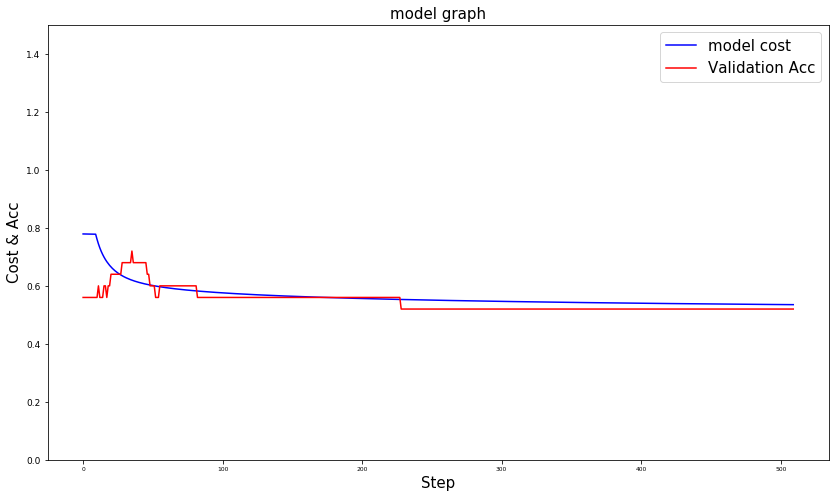

In [35]:
plt.figure(figsize=(14, 8))
plt.ylim([0,1.5])
plt.plot(graph_cost, color = 'blue', label = 'model cost')
plt.plot(graph_acc, color = 'red', label = 'Validation Acc')
plt.title('model graph')
plt.xlabel('Step')
plt.ylabel('Cost & Acc')
plt.legend()
plt.show()

# <span style="color:red"> 비 가치주로 validation

In [29]:
# x_val_data = scale_sds
# y_val_data = deep_sds.iloc[:,[-1]]
x_val_data = scale_IT_validation
y_val_data = deep_IT_validation.iloc[:,[-1]]

# samsungelectric
# lgelectric
# sds
# lgdisplay

graph_cost = []
graph_acc = []

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(20001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data, Y: y_data, keep_prob: 1.0})       
        if step % 200 == 0 or step < 10 :
            h, c, a = sess.run([hypothesis, predicted, accuracy],
                               feed_dict={X: x_val_data.iloc[:,:], Y: y_val_data.iloc[:,:], keep_prob: 1.0})
            graph_cost.append(cost_val)
            graph_acc.append(a)
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    
  

Step : 0 	 Cost : 0.7614119648933411 	 Acc : 56.48148059844971
Step : 1 	 Cost : 0.7613201141357422 	 Acc : 56.48148059844971
Step : 2 	 Cost : 0.7612283825874329 	 Acc : 56.48148059844971
Step : 3 	 Cost : 0.7611368298530579 	 Acc : 56.48148059844971
Step : 4 	 Cost : 0.7610451579093933 	 Acc : 56.48148059844971
Step : 5 	 Cost : 0.7609537839889526 	 Acc : 56.48148059844971
Step : 6 	 Cost : 0.7608624696731567 	 Acc : 56.48148059844971
Step : 7 	 Cost : 0.7607712149620056 	 Acc : 56.48148059844971
Step : 8 	 Cost : 0.7606800198554993 	 Acc : 56.48148059844971
Step : 9 	 Cost : 0.7605890035629272 	 Acc : 56.48148059844971
Step : 200 	 Cost : 0.744822084903717 	 Acc : 57.40740895271301
Step : 400 	 Cost : 0.7310999035835266 	 Acc : 57.40740895271301
Step : 600 	 Cost : 0.7194638252258301 	 Acc : 58.33333134651184
Step : 800 	 Cost : 0.7094061970710754 	 Acc : 60.18518805503845
Step : 1000 	 Cost : 0.700592577457428 	 Acc : 59.25925970077515
Step : 1200 	 Cost : 0.6927947998046875 	 Acc 

In [30]:
print('모델 최고 정확도: ', max(graph_acc) * 100 , '%')

모델 최고 정확도:  63.88888955116272 %


In [1]:
plt.figure(figsize=(14, 8))
plt.ylim([0,1.5])
plt.plot(graph_cost, color = 'blue', label = 'model cost')
plt.plot(graph_acc, color = 'red', label = 'Validation Acc')
plt.title('model graph')
plt.xlabel('Step')
plt.ylabel('Cost & Acc')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [63]:
pd.DataFrame({'real':list(y_val_data.values.ravel()),'predict': list(c.ravel())})

,real,predict
0,1.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,1.0,0.0
5,0.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,0.0,0.0


삼성전자
18/1분기 0 / 0 (2분기를 예측)
18/2분기 0 / 1 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

lg전자
18/1분기 1 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

삼성sds
18/1분기 1 / 1 (2분기를 예측)
18/2분기 0 / 1 (3분기를 예측)
18/3분기 1 / 1 (4분기를 예측)

lg디스플레이
18/1분기 0 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 1 / 1 (4분기를 예측)


1분기
삼성sds - 이득(실제도 오름)

2분기
삼성전자 - 손해(실제는 떨어짐)
삼성sds - 손해(실제는 떨어짐)

3분기
삼성전자 - 손해(실제는 떨어짐)
lg전자 - 손해(실제는 떨어짐)
삼성sds - 이득(실제 오름)
lg디스플레이 - 이득(실제 오름)

하이닉스
18/1분기 1 / 0 (2분기를 예측)
18/2분기 1 / 0 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)

삼성전기
18/1분기 1 / 0 (2분기를 예측)
18/2분기 0 / 0 (3분기를 예측)
18/3분기 0 / 1 (4분기를 예측)

삼성sdi
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 1 / 0 (4분기를 예측)

lg전자
18/1분기 0 / 0 (2분기를 예측)
18/2분기 1 / 1 (3분기를 예측)
18/3분기 0 / 0 (4분기를 예측)


1분기
없음(전부 떨어진다고 예측)

2분기
삼성sdi - 이득(실제 오름)
lg전자 - 이득(실제 오름)

3분기
삼성전기 - 손해(실제는 떨어짐)

it 8개 주식

1분기
삼성sds - 이득(실제도 오름)

2분기
삼성sdi - 이득(실제 오름)
lg전자 - 이득(실제 오름)
삼성전자 - 손해(실제는 떨어짐)
삼성sds - 손해(실제는 떨어짐)

3분기
삼성전자 - 손해(실제는 떨어짐)
lg전자 - 손해(실제는 떨어짐)
삼성sds - 이득(실제 오름)
lg디스플레이 - 이득(실제 오름)
삼성전기 - 손해(실제는 떨어짐)